# Na wstępie

Ukończyłem Wakacyjne Wyzwanie Solvro, ale jednocześnie brałem udział w kursie Machine Learning Specialization by Andrew Ng i chciałem się trochę pobawić / utrwalić swoje wiadomości z tego zakresu 


In [1]:
import os
import kaggle
import splitfolders 
import tensorflow as tf
import shutil
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, 
    Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix




### pobranie i posortowanie datasetu


In [2]:
SEED = 857191091 #dzwon smialo 
data_path = './data'
data_tmp = './data_tmp'

tensor = tf.constant([])
print(tensor.device)

tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.config.experimental.enable_op_determinism()

if os.path.exists(data_path):
    print("Dane sa juz pobrane")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('gergvincze/simple-hand-drawn-and-digitized-images', path=data_tmp, unzip=True)
    splitfolders.ratio(input=data_tmp, move=True, output=data_path, seed=SEED, ratio=(0.7, 0.15, 0.15))
    shutil.rmtree(data_tmp)

/job:localhost/replica:0/task:0/device:CPU:0
Dane sa juz pobrane


analiza danych była już w zadanie.ipynb więc tutaj pominę ten etap 

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 130)

train_ds = image_dataset_from_directory(
    'data/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',  
    shuffle=True,
    seed=SEED
)

test_ds = image_dataset_from_directory(
    'data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

val_ds = image_dataset_from_directory(
    'data/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

class_names = train_ds.class_names



Found 297 files belonging to 10 classes.
Found 74 files belonging to 10 classes.
Found 60 files belonging to 10 classes.


In [4]:
print(f"klasy: {train_ds.class_names}")
print(f"liczba klas: {len(train_ds.class_names)}")

klasy: ['anchor', 'balloon', 'bicycle', 'envelope', 'paper_boat', 'peace_symbol', 'smiley', 'speech_bubble', 'spiral', 'thumb']
liczba klas: 10


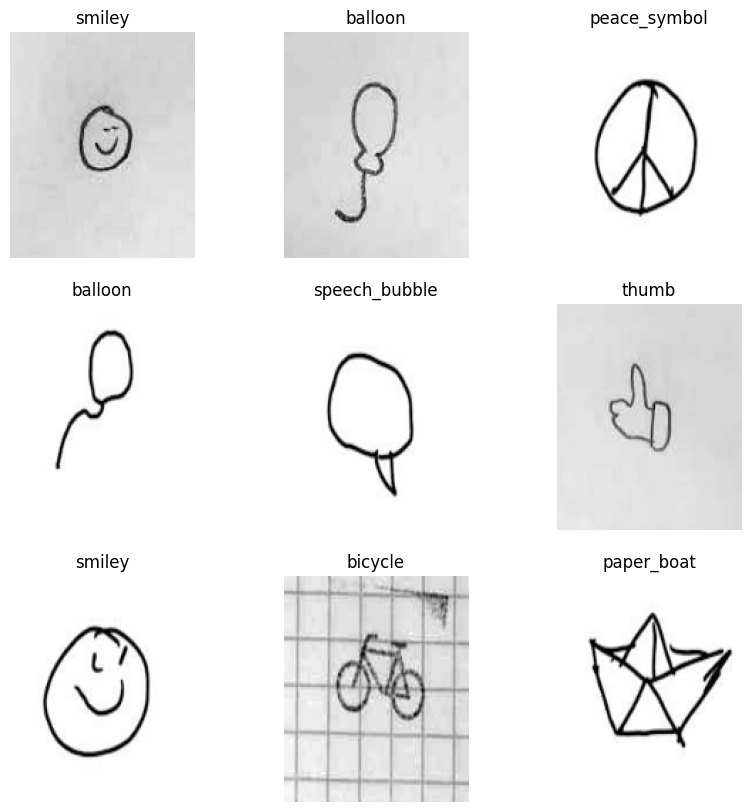

In [5]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
    break

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(32, 160, 130, 1)
(32, 10)
(9, 160, 130, 1)
(9, 10)


2025-10-22 15:50:42.801795: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-10-22 15:50:42.925298: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_5}}


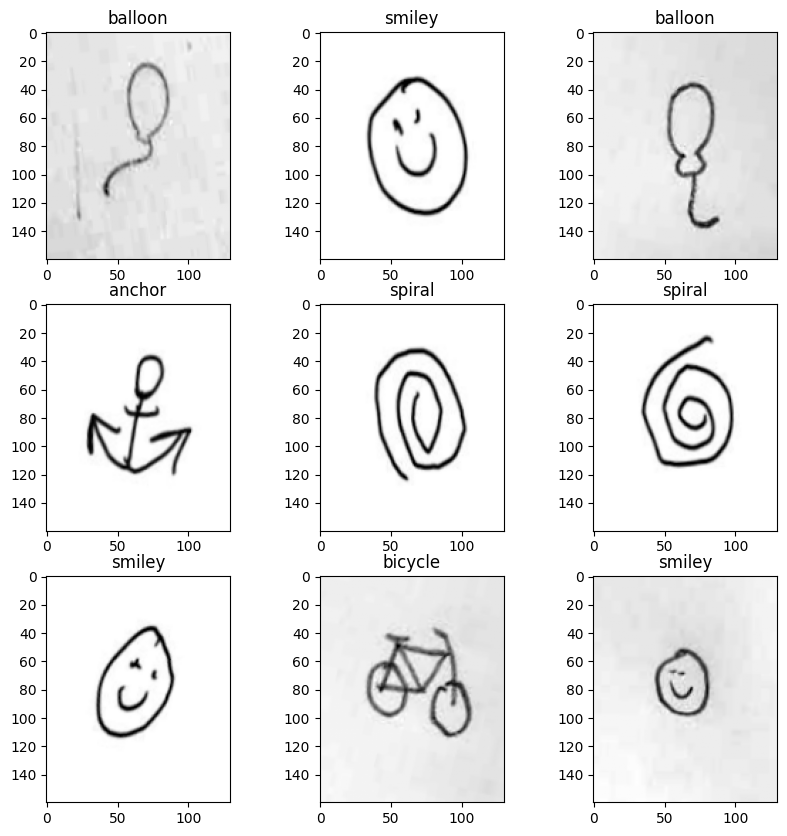

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#roatacja bo niektore obrazki byly krzywe i aby sie nie przyuczyl 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1)
])

AUTOTUNE = tf.data.AUTOTUNE
#znormalizowanie danych grayscale do przedizalu [0,1]
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
#zapamietanie danych w RAM
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(AUTOTUNE)


for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
    plt.show()
    break

In [8]:
model = Sequential([
    Input(shape=(160, 130, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(), 
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='linear')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,257,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353,034 (31.86 MB)

 Trainable params: 8,353,034 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_dir = "NajlepszyModel.keras"
if os.path.exists(model_dir):
    print("wczytano model")
    model = load_model(model_dir)
else:
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=['accuracy']
    )
    checkpoint = ModelCheckpoint(
        "NajlepszyModel.keras",
        monitor="val_loss",    
        save_best_only=True,       
        mode="min",                
        verbose=1                  
    )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=40,
        callbacks=[checkpoint]
    )

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1039 - loss: 2.4919
Epoch 1: val_loss improved from None to 2.29705, saving model to NajlepszyModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.1044 - loss: 2.4069 - val_accuracy: 0.1167 - val_loss: 2.2971
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1170 - loss: 2.2945
Epoch 2: val_loss improved from 2.29705 to 2.26694, saving model to NajlepszyModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.1246 - loss: 2.2982 - val_accuracy: 0.2000 - val_loss: 2.2669
Epoch 3/40
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2536 - loss: 2.2135
Epoch 3: val_loss improved from 2.26694 to 1.99122, saving model to NajlepszyModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2290 - loss: 2.1800 - val_accuracy: 0.4500 - val_loss: 1.9912
Epoch 4/40
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4231 - loss: 1.8855
Epoch 4: val_loss improved from 1.99122 t

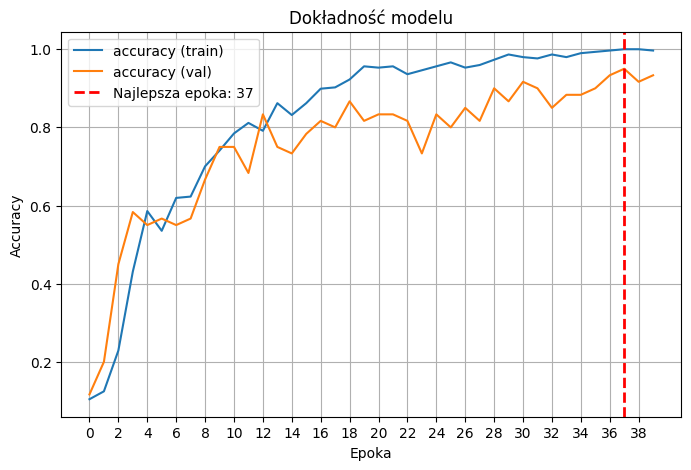

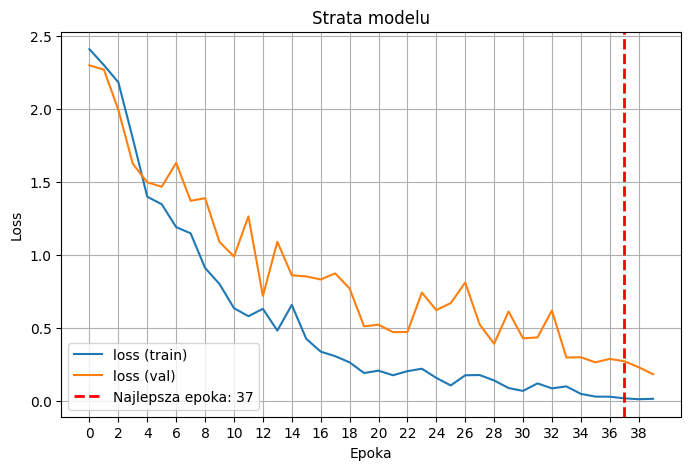

In [10]:
best_epoch = np.argmax(history.history['val_accuracy'])

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='accuracy (train)')
plt.plot(history.history['val_accuracy'], label='accuracy (val)')
plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Najlepsza epoka: {best_epoch}')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.xticks(range(0, len(history.history['accuracy']), 2)) 
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='loss (train)')
plt.plot(history.history['val_loss'], label='loss (val)')
plt.title('Strata modelu')
plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Najlepsza epoka: {best_epoch}')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.xticks(range(0, len(history.history['loss']),2))  
plt.legend()
plt.grid(True)
plt.show()


I tak w sumie jako ze tf pozwala sledzic tylko 1 parametr to nie mozna byc w 100 % pewnym ze wybral najlepsze możliwe parametry dla naszego modelu 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2025-10-22 15:51:35.584796: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


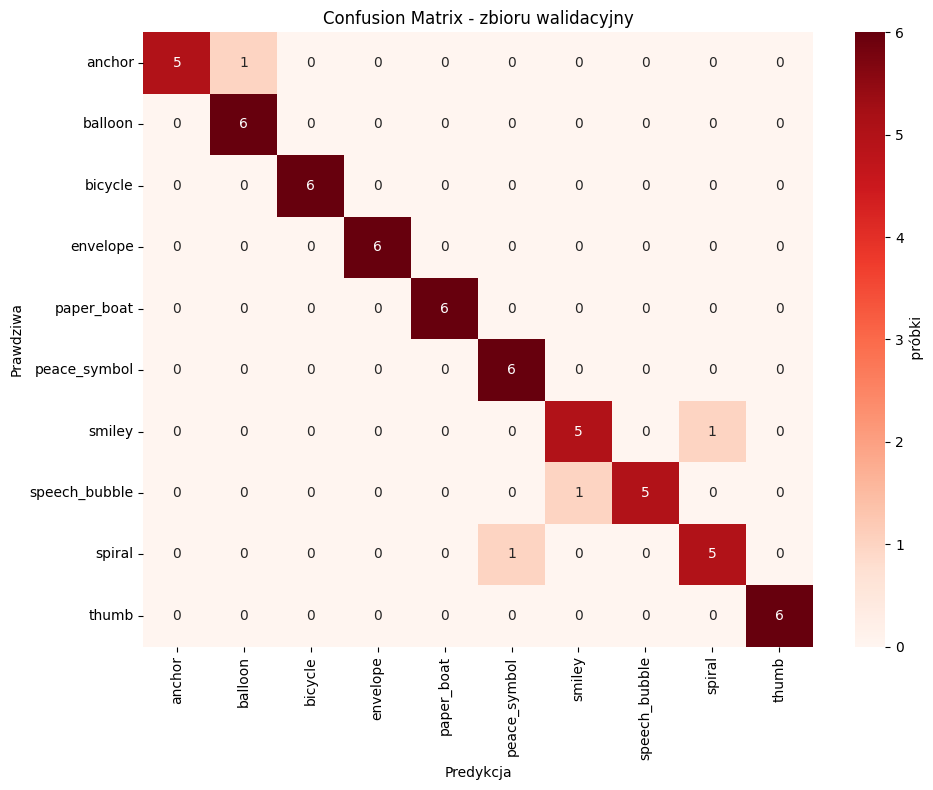

               precision    recall  f1-score   support

       anchor       1.00      0.83      0.91         6
      balloon       0.86      1.00      0.92         6
      bicycle       1.00      1.00      1.00         6
     envelope       1.00      1.00      1.00         6
   paper_boat       1.00      1.00      1.00         6
 peace_symbol       0.86      1.00      0.92         6
       smiley       0.83      0.83      0.83         6
speech_bubble       1.00      0.83      0.91         6
       spiral       0.83      0.83      0.83         6
        thumb       1.00      1.00      1.00         6

     accuracy                           0.93        60
    macro avg       0.94      0.93      0.93        60
 weighted avg       0.94      0.93      0.93        60



In [11]:

y_val_pred_labels = np.argmax(model.predict(val_ds), axis=1)

y_val_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in val_ds])

cm = confusion_matrix(y_val_true, y_val_pred_labels)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
           xticklabels=class_names, 
           yticklabels=class_names,
           cbar_kws={'label': ' próbki'})
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa')
plt.title('Confusion Matrix - zbioru walidacyjny')
plt.tight_layout()
plt.show()

print(classification_report(y_val_true, y_val_pred_labels, target_names=class_names))


0.93 acc na zbiorze walidacyjny no nie jest dobrze nie jest też tragicznie 
<br>smiley i spiral sobie najgorzej poradzili 0.83 f1 scora 

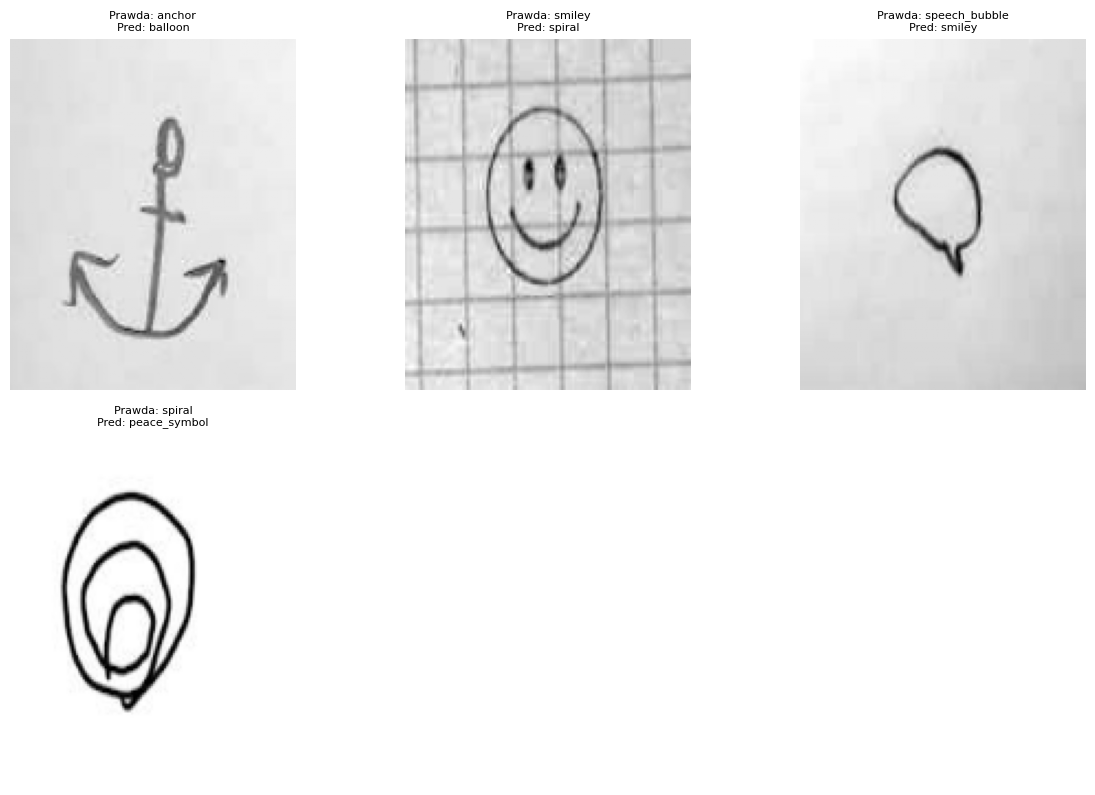

In [12]:
images = np.concatenate([imgs.numpy() for imgs, _ in val_ds])
incorrect_indices = np.where(y_val_pred_labels != y_val_true)[0]

num_show = min(25, len(incorrect_indices))
plt.figure(figsize=(12, 12))

for i, idx in enumerate(incorrect_indices[:num_show]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    true_label = class_names[y_val_true[idx]]
    pred_label = class_names[y_val_pred_labels[idx]]
    plt.title(f"Prawda: {true_label}\nPred: {pred_label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

Nasz model nie radzi sobie za bardzo z rzeczami znajdujacymi sie na kartce papieru 
<br>
Można by pobawić się jeszcze wagami czy spróbować algorytmu w kanałach rgb, ale myślę że wynik nie jest tragiczny jak na tak mały dataset 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8784 - loss: 0.4275
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-10-22 15:59:31.352435: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


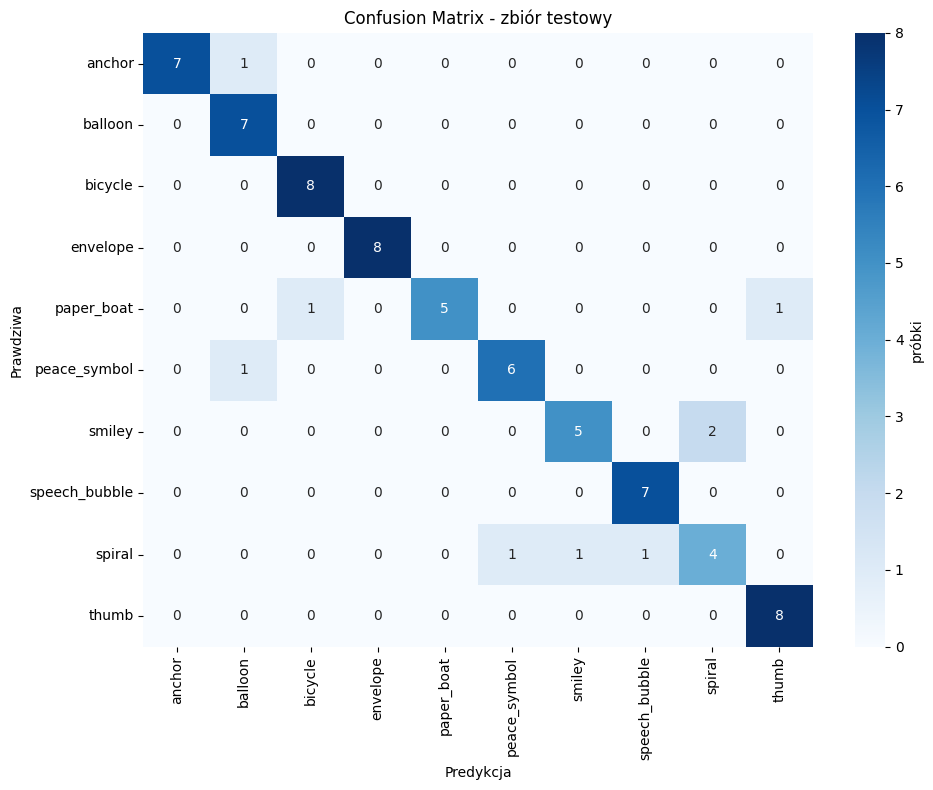

               precision    recall  f1-score   support

       anchor       1.00      0.88      0.93         8
      balloon       0.78      1.00      0.88         7
      bicycle       0.89      1.00      0.94         8
     envelope       1.00      1.00      1.00         8
   paper_boat       1.00      0.71      0.83         7
 peace_symbol       0.86      0.86      0.86         7
       smiley       0.83      0.71      0.77         7
speech_bubble       0.88      1.00      0.93         7
       spiral       0.67      0.57      0.62         7
        thumb       0.89      1.00      0.94         8

     accuracy                           0.88        74
    macro avg       0.88      0.87      0.87        74
 weighted avg       0.88      0.88      0.87        74



In [13]:
model.evaluate(test_ds)

y_test_pred = model.predict(test_ds)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in test_ds])

cm_test = confusion_matrix(y_test_true, y_test_pred_labels)

plt.figure(figsize=(10, 8))
sn.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, 
           yticklabels=class_names,
           cbar_kws={'label': 'próbki'})
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa')
plt.title('Confusion Matrix - zbiór testowy')
plt.tight_layout()
plt.show()

print(classification_report(y_test_true, y_test_pred_labels, target_names=class_names))

Nasz model nie radzi sobie z okrągłymi krawędziami źle sklasyfikuje smiley, spiral, trzeba by dołożyć jeszcze jedną warstwę konwoluucyjną może to by pomogło. ❤️